In [6]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

In [7]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx  #存储知识图谱图数据的组键

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [8]:
# import wikipedia sentences
candidate_sentences = pd.read_csv('wiki_sentences_v2.csv')
candidate_sentences.shape
candidate_sentences.head(5)
candidate_sentences.head(10)

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
5,it's a parable of a woman's religious awakening—
6,"c. mackenzie, and craig vincent joined the cast."
7,"later, craig di francia and action bronson were revealed to have joined the cast."
8,sebastian maniscalco and paul ben-victor were later revealed as being part of the cast.
9,we just tried to make the film.


In [9]:
candidate_sentences['sentence'].sample(5)

3031      meanwhile, industrial light & magic was struggling to achieve unprecedented special effects.
631                zombie's second studio album, the sinister urge, was released on november 13, 2001.
4011      the first film to be released with this rating was the 1984 john milius war film red dawn.  
3104    last call is a 2012 american independent comedy film and the directorial debut of greg garthe.
3813                                        its closest rival, failure to launch, took in $15,604,892.
Name: sentence, dtype: object

In [10]:
doc = nlp('the drawdown process is governed by the drawdown rate and the drawdown time.')
print(doc)
for tok in doc:
    print('.',tok.text, tok.dep_, tok.head.text, tok.head.dep_)

doc1 = nlp('the drwadown process is governed by astm standard d823')
print(doc1)
for tok in doc1:
    print(tok.text,'...',tok.dep_,'.')

the drawdown process is governed by the drawdown rate and the drawdown time.
. the det process nsubjpass
. drawdown compound process nsubjpass
. process nsubjpass governed ROOT
. is auxpass governed ROOT
. governed ROOT governed ROOT
. by agent governed ROOT
. the det rate pobj
. drawdown compound rate pobj
. rate pobj by agent
. and cc rate pobj
. the det time conj
. drawdown amod time conj
. time conj rate pobj
. . punct governed ROOT
the drwadown process is governed by astm standard d823
the ... det .
drwadown ... amod .
process ... nsubjpass .
is ... auxpass .
governed ... ROOT .
by ... agent .
astm ... compound .
standard ... amod .
d823 ... pobj .


In [11]:
def get_entities(sent):
    ## chunk1
    """
    在这个快中定义了一些空变量。prv_tok_dep和prv_tok_text将保存句子中的前一个单词的依赖标签和前一个单词本身
    prefix和modifier将保存与主语或宾语相关联的文本
    """
    ent1 = ''
    ent2 = ''

    prv_tok_dep = ''
    prv_tok_text = ''

    prefix = ''
    modifier = ''

    ############################################################
    ## chunk2
    """
    接下来，我们将循环遍历句子中的标记。我们将首先检查标记是否是标点符号
    如果是，我们将跳过它，并进行下一个标记
    如果标记是复合词（依赖标签是‘compound’），我们将其保留在prefix变量中
    复合词是指由两个或多个单词组合而成的单词，例如“drawdown rate”或“drawdown time”

    每当我们遇到主语或宾语时，我们将此前缀添加到其中。我们将对修饰词进行相同的操作，例如‘漂亮的衬衫’，‘大房子’等
    """
    for tok in nlp(sent):
        if tok.dep_ != 'punct':
            if tok.dep_ == 'compound':
                prefix = tok.text
                if prv_tok_dep == 'compound':
                    prefix = prv_tok_text + ' ' + tok.text
                
            if tok.dep_.endswith('mod') == True:
                modifier = tok.text
                if prv_tok_dep == 'compound':
                    modifier = prv_tok_text + ' ' + tok.text

            ## chunk3
            """
            如果标记是主语，就将其作为ent1变量中的第一个实体捕获。前缀、修饰词、prv_tok_text和prv_tok_dep等变量将被重置
            """
            if tok.dep_.find("subj") == True:
               ent1 = modifier + ' ' + prefix + ' ' + tok.text
               prefix = ''
               modifier = ''
               prv_tok_text = ''
               prv_tok_dep = ''

            ## chunk4
            """
            如果标记是宾语，就将其作为ent2变量中的第二个实体捕获。前缀、修饰词、prv_tok_text和prv_tok_dep等变量将被再次重置
            """
            if tok.dep_.find("obj") == True:
               ent2 = modifier + ' ' + prefix + ' ' + tok.text
    
            ## chunk5
            """
            一旦我们在句子中捕获了主语和宾语，我们将更新前一个标记及其依赖标签
            """
            # update variables
            prv_tok_text = tok.text
            prv_tok_dep = tok.dep_
    ################################################################
    return [ent1.strip(), ent2.strip()]


In [12]:
# 在一个句子上测试一下这个函数
print(get_entities('the drawdown process is governed by the drawdown rate and the drawdown time.'))
print(get_entities('this country owns 56 peoples and 36 provinces'))


['drawdown process', 'drawdown rate']
['country', '56  peoples']


In [13]:
entity_pairs = []

for i in tqdm(candidate_sentences['sentence']):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:25<00:00, 170.01it/s]


In [14]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [15]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # define the pattern
    patterns = [
        [{'DEP' : 'ROOT'}, {'DEP' : 'prep','OP' : '?'}, {'DEP' : 'agent','OP':'?'}, {"POS":'ADJ','OP':'?'}]
    ]

    # matcher.add('matching_1', None, pattern)
    for i, pattern in enumerate(patterns):
        matcher.add(f"pattern{i+1}",[pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]]

    return(span.text)

In [16]:
get_relation('John completed the task')

'completed'

In [17]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:27<00:00, 159.45it/s]


In [18]:
pd.Series(relations).value_counts()[:50]

is               365
was              301
released on       88
are               73
include           70
were              69
released          39
's                36
composed by       35
became            32
have              31
has               30
become            28
released in       27
included          24
produced          21
called            20
been              19
had               19
considered        18
used              18
be                18
made              18
scheduled         15
stars             15
directed by       15
produced by       14
hired             14
set               14
went              13
introduced in     13
received          13
wrote             12
wanted            12
written by        12
began in          11
began             11
won               11
cast as           11
gave              10
includes          10
sold              10
opened             9
used in            9
directed           9
gives              9
produced in        9
features     

In [19]:
# extract the subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs] 

kg_df = pd.DataFrame({'source':source,'target':target,'edge':relations})

In [20]:
# create a direct_graph from a dataframe
G = nx.from_pandas_edgelist(kg_df,'source','target',
                            edge_attr=True, create_using=nx.MultiDiGraph())

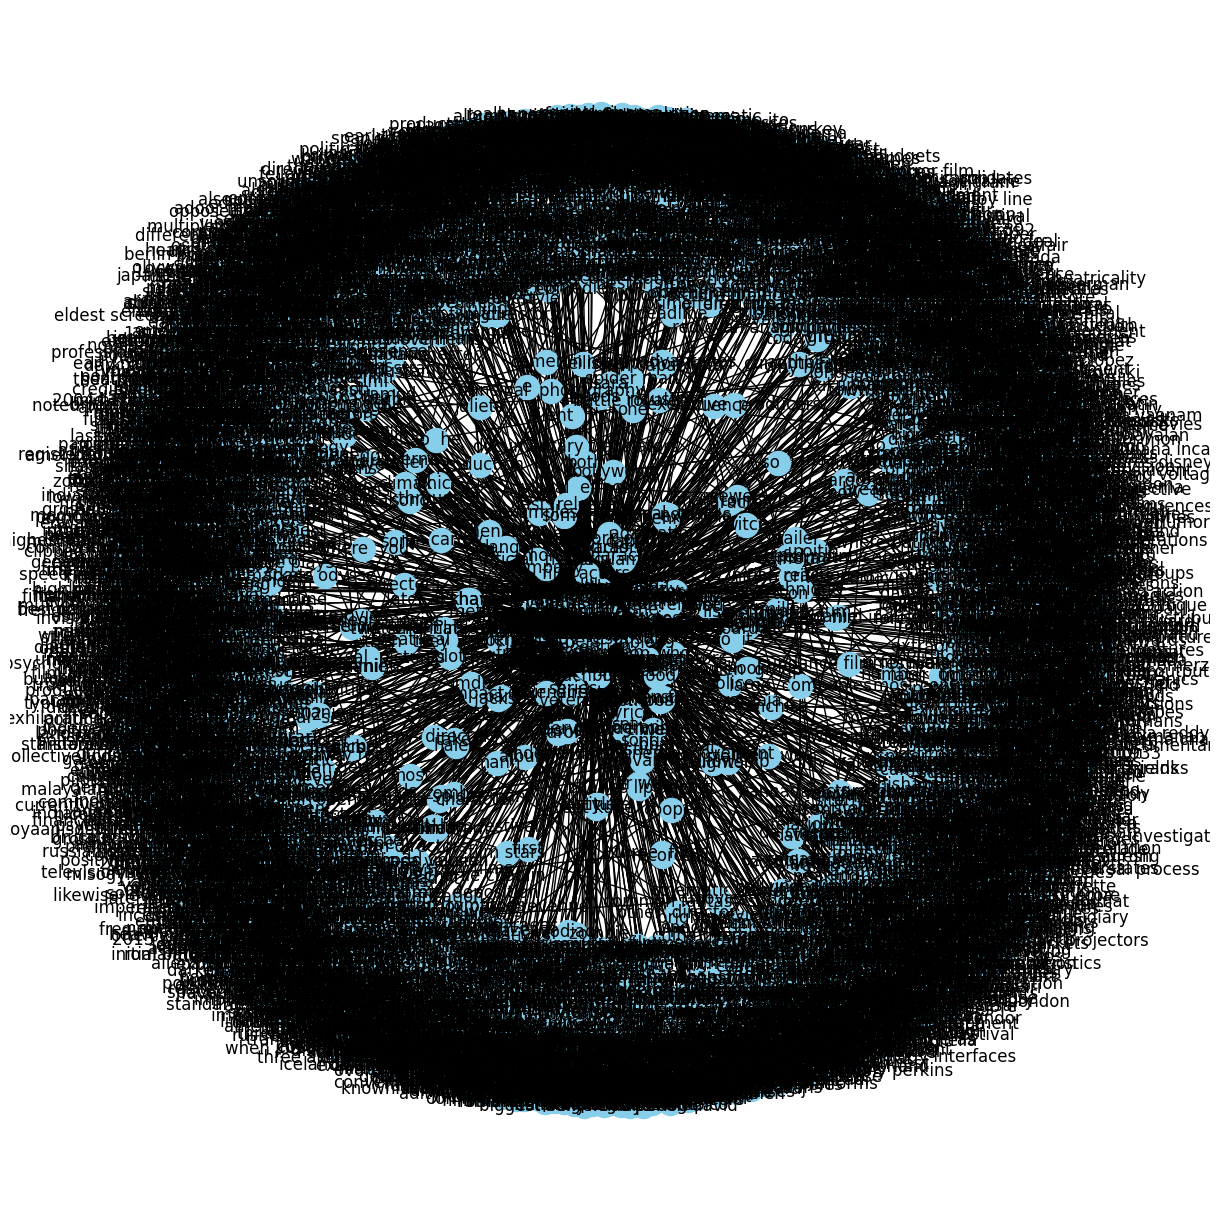

In [21]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

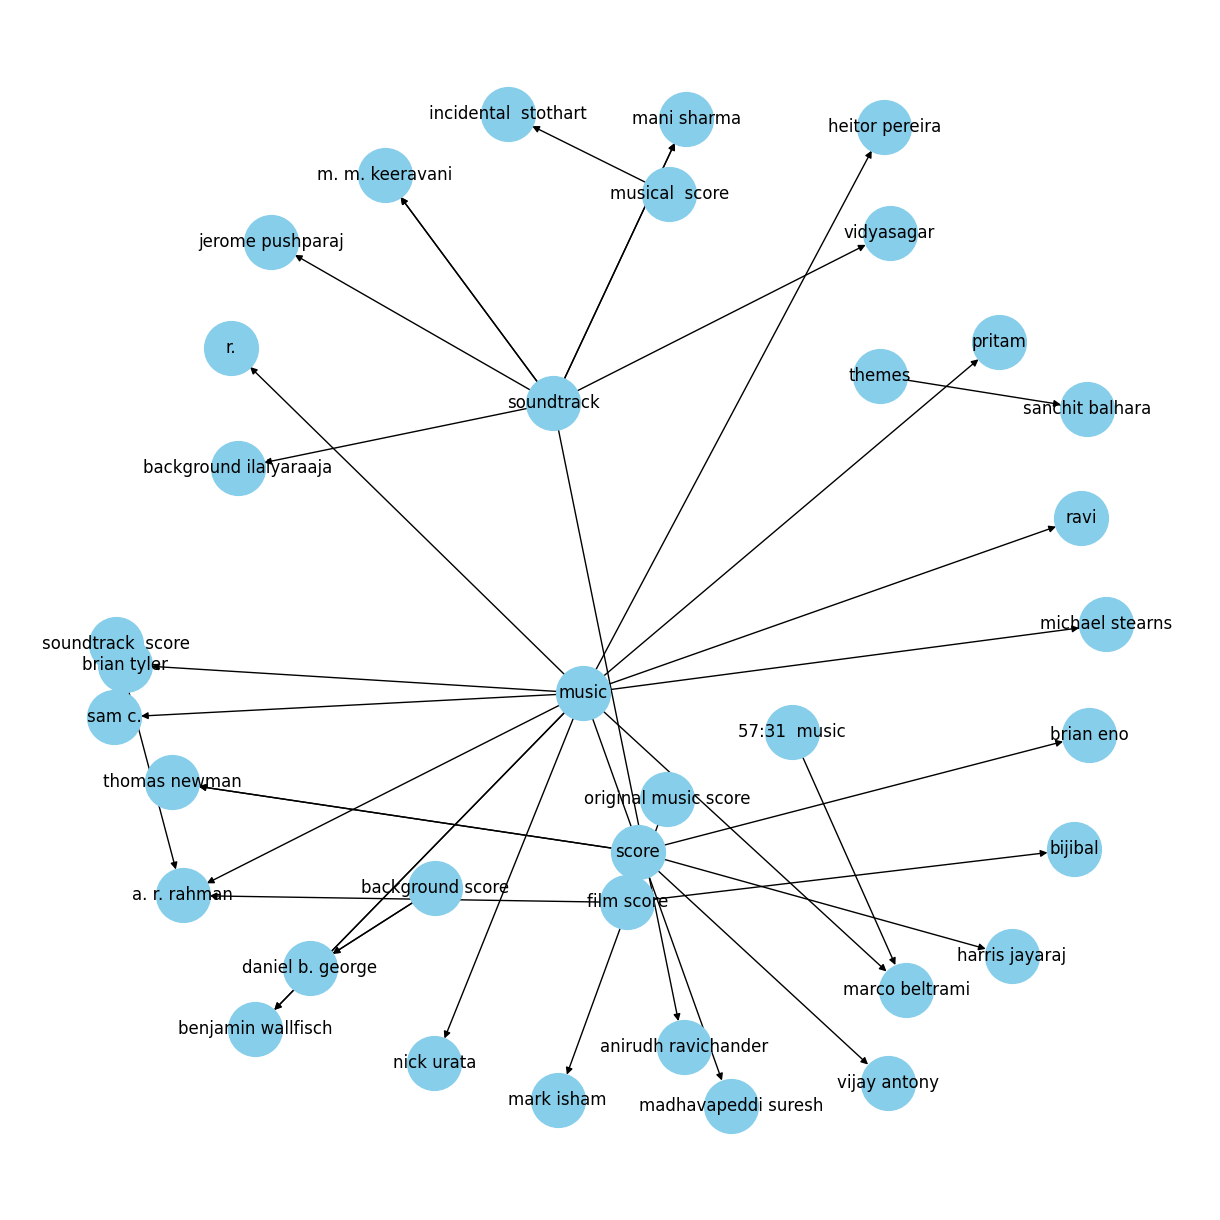

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance betweeen nodes
nx.draw(G, with_labels=True, node_color='skyblue',node_size = 1500, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()